In [ ]:
# !conda install --yes --prefix {sys.prefix} scikit-image
# !pip3 install scikit-image

In [70]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data
from skimage import io, transform
from skimage.measure import block_reduce
import numpy as np
import torch
import torch.utils.data

In [71]:
def get_photo_file(photo_name):
    return "data/yelp_photos/photos/" + photo_name + ".jpg"

def resize_img(img):
    return transform.resize(img, (200, 200))

In [122]:
class YelpDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, batch_size, shuffle=True):
        self.df = df 
        self.batch_size = batch_size
        if shuffle:
            self.df = self.df.sample(frac=1)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        photo_names = self.df.iloc[idx:idx+self.batch_size].index.tolist()
        file_names = [get_photo_file(photo_name) for photo_name in photo_names]
        images = [io.imread(file_name) for file_name in file_names]
        images = [resize_img(img) for img in images] 
        label = self.df.iloc[idx:idx+self.batch_size].label.tolist()
        return (torch.Tensor(images),torch.Tensor(label))

In [4]:
biz_df = pd.read_csv("data/clean_business.csv").set_index("business_id")
photo_df = pd.read_csv("data/clean_photo.csv").set_index("photo_id")
df = photo_df.copy(deep=True)
df["label"] = pd.Series(biz_df.loc[df["business_id"]]["stars"]).tolist()

/usr/local/opt/python3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


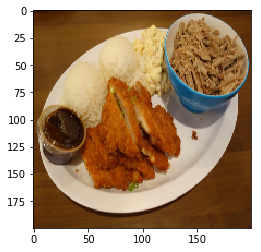

In [127]:
plt.imshow(YelpDataset(df, batch_size=32)[0][0][0])

In [97]:
df.iloc[3:3+(2)].index

Index(['jQyiq-HX3mUCXOyQ0lc0QA', '_ExrVJTjGcChfzLH51etAw'], dtype='object', name='photo_id')